In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [179]:
TC = np.load('ExpTF_exc_Nstp20.npy').T
RE = np.load('ExpTF_inh_Nstp20.npy').T
ve = np.linspace(0, 35, 20)
vi = np.linspace(0, 160, 20)
vve, vvi = np.meshgrid(ve, vi)

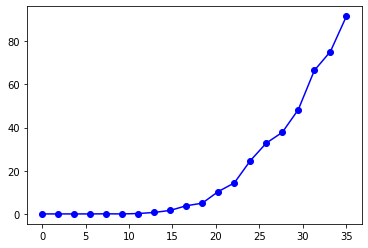

In [183]:
plt.plot(ve, TC[19], '-ob')

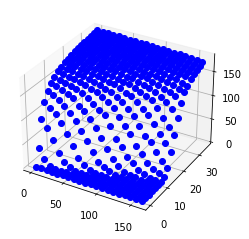

In [185]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.plot3D(vvi.flatten(), vve.flatten(), RE.flatten(), 'ob')

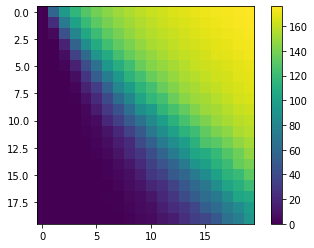

In [186]:
plt.imshow(TC)
plt.colorbar()

In [214]:
def MPF(fexc,finh,fout,Qe,Qi,Cm,El,a,Nexc,Ninh):

    fe = fexc*Nexc
    fi = finh*Ninh

    fe+=1e-9;
    fi+=1e-9;
    
    muGi = Qi*Ti*fi;
    muGe = Qe*Te*fe;
    muG = Gl+muGe+muGi;
    # muV = (muGe*Ee+muGi*Ei+Gl*El-adapt)/muG;
    muV = (muGe*Ee+muGi*Ei+Gl*El - fout*Tw*b + a*El)/(muG+a);
    
    
    muGn = muG/Gl;
    Tm = Cm/muG;
    
    Ue =  Qe/muG*(Ee-muV);
    Ui = Qi/muG*(Ei-muV);
    
    sV = np.sqrt(fe*(Ue*Te)*(Ue*Te)/2./(Te+Tm)+fi*(Ui*Ti)*(Ui*Ti)/2./(Ti+Tm));
    
    
    fe+=1e-9;
    fi+=1e-9;
    Tv = ( fe*(Ue*Te)*(Ue*Te) + fi*(Qi*Ui)*(Qi*Ui)) /( fe*(Ue*Te)*(Ue*Te)/(Te+Tm) + fi*(Qi*Ui)*(Qi*Ui)/(Ti+Tm) );
    TvN = Tv*Gl/Cm;

    return muV, sV, Tv, TvN

# constants
Gl=10*1.e-9
Tw=200*1.e-3
b=0.01*1e-9

Ti=5*1.e-3
Te=5*1.e-3
Ee=0
Ei=-80*1.e-3


In [215]:
# m, s, t, tN = MPF(4, 30, 4, Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-55e-3,a=0,Nexc=800,Ninh=25)
# m, s, t, tN = MPF(4, 40, 30, Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3,a=8e-9,Nexc=400,Ninh=150)
# m, s, tN

In [216]:
from scipy.special import erf, erfc, erfcinv

In [217]:
def pheV(fout, muV, sV, Tv):
    fout+=1e-9
    Tv+=1e-9
    return np.sqrt(2)*sV * erfcinv( 2*Tv*fout ) + muV # Zerlaut 2017
    # return np.sqrt(2)*sV * erfcinv( Tv*fout ) + muV # to widen the definition range
# pheV(4 ,muV, sV, Tv)

In [218]:
#======calculate MPF for TC/RE=======
# muV, sV, Tv, TvN = MPF(vve, vvi, TC, Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-65e-3,a=0,Nexc=800,Ninh=25)
muV, sV, Tv, TvN = MPF(vve, vvi, RE, Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3,a=8e-9,Nexc=400,Ninh=150)

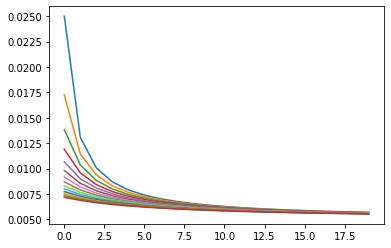

In [219]:
for i in range(14):
    plt.plot(Tv[i])

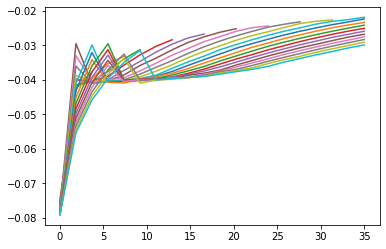

In [220]:
#======calculate phe Vthre eff======
Veff = pheV(RE, muV, sV, Tv)
for i in range(len(vi)):
    plt.plot(ve, Veff[i])

In [228]:
idx = '[9:,:]'
exec(f"Veff_fit = Veff{idx}")
exec(f"TC_fit = TC{idx}")
exec(f"RE_fit = RE{idx}")
exec(f"muV_fit = muV{idx}")
exec(f"sV_fit = sV{idx}")
exec(f"Tv_fit = Tv{idx}")
exec(f"TvN_fit = TvN{idx}")
Veff_fit.shape

(11, 20)

In [229]:
from scipy.optimize import minimize
def Vthre(P, muV, sV, TvN):
    muV0 = -60e-3;
    DmuV0 = 10e-3;
    sV0 = 4e-3;
    DsV0 = 6e-3;
    TvN0 = 0.5;
    DTvN0 = 1.;
    
    Vo1 = P[0] + P[1]*(muV-muV0)/DmuV0 + P[2]*(sV-sV0)/DsV0 + P[3]*(TvN-TvN0)/DTvN0
    Vo2 = P[4]*((muV-muV0)/DmuV0)*((muV-muV0)/DmuV0) + P[5]*(muV-muV0)/DmuV0*(sV-sV0)/DsV0 + P[6]*(muV-muV0)/DmuV0*(TvN-TvN0)/DTvN0 + P[7]*((sV-sV0)/DsV0)*((sV-sV0)/DsV0) + P[8]*(sV-sV0)/DsV0*(TvN-TvN0)/DTvN0  + P[9]*((TvN-TvN0)/DTvN0)*((TvN-TvN0)/DTvN0);

    return Vo1 + Vo2
    

In [230]:
def Res(P):
    return np.mean( (Veff_fit - Vthre(np.concatenate([P,[0]*6]), muV_fit, sV_fit, TvN_fit))**2 )
res = minimize(Res, [Veff_fit.mean(),1e-3,1e-3,1e-3], method='nelder-mead', options={'xtol':1e-20,'disp':True,'maxiter':20000})
P1 = np.array(res.x)
print(P1)

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 334
         Function evaluations: 680
[-0.04728168  0.00588872  0.03433101 -0.03834682]


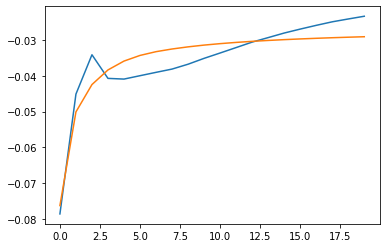

In [231]:
i =2
plt.plot(Veff_fit[i])
plt.plot(Vthre(np.concatenate([P1,[0]*6]), muV_fit, sV_fit, TvN_fit)[i])

In [232]:
def Res(P):
    return np.mean( (Veff_fit - Vthre(np.concatenate([P1,P]), muV_fit, sV_fit, TvN_fit))**2 )
res = minimize(Res, [0]*6, method='nelder-mead', options={'xtol':1e-20,'disp':True,'maxiter':20000})
P2 = np.array(res.x)
print(P2)

[-1.38672787e-04 -2.98007864e-02  4.77725719e-02  1.10133618e-01
 -3.54063156e-01  3.47993740e-01]


In [146]:
P = np.concatenate([P1,P2])

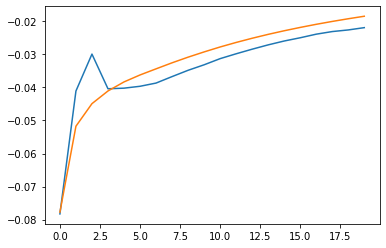

In [234]:
i =0
plt.plot(Veff_fit[i])
plt.plot(Vthre(P, muV_fit, sV_fit, TvN_fit)[i])

In [235]:
def TF(P, muV, sV, Tv, TvN):
    return 1/(2*Tv) * erfc( (Vthre(P, muV, sV, TvN) - muV)/(np.sqrt(2)*sV) )

In [236]:
def Res(P):
    # return np.mean( (TC_fit - TF(P, muV_fit, sV_fit, Tv_fit, TvN_fit))**2 )
    return np.mean( (RE - TF(P, muV, sV, Tv, TvN))**2 )
res = minimize(Res, P, method='nelder-mead', options={'xtol':1e-32,'disp':True,'maxiter':40000})
PP = np.array(res.x)
print(PP)

[-0.04665356  0.00284469  0.02614398 -0.01072509 -0.00011288 -0.01041685
 -0.00176862  0.00992084 -0.00410924  0.00641952]


In [237]:
TF(PP, muV, sV, Tv, TvN)[5]

array([1.67139639e-15, 1.19252308e-02, 4.34469997e+00, 3.83106921e+01,
       8.95873946e+01, 1.27944793e+02, 1.46246213e+02, 1.54714064e+02,
       1.59306803e+02, 1.62469172e+02, 1.64995833e+02, 1.67148514e+02,
       1.69034222e+02, 1.70709335e+02, 1.72210459e+02, 1.73564443e+02,
       1.74792301e+02, 1.75911025e+02, 1.76934610e+02, 1.77874724e+02])

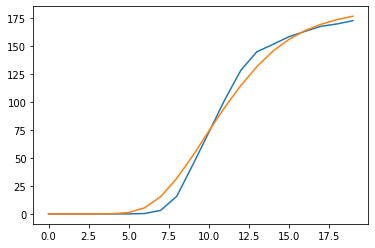

In [246]:
# for i in range(0,3):
#     print(vi[i])
i = 19
plt.plot(RE[i])
plt.plot(TF(PP, muV, sV, Tv, TvN)[i])

In [ ]:
#=====SAVE TC/RE======
np.save('NEW2params_RE.npy', PP)

___

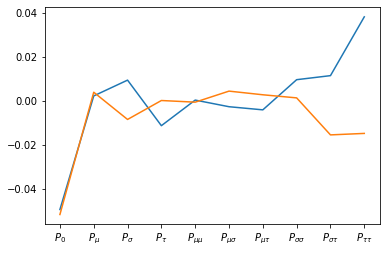

In [222]:
pZ=np.load("C:\VSCode\DB_comparison\mf\data\FS-cell_CONFIG1_fit.npy")[[0,1,2,3,5,8,9,6,10,7]]
RE=np.load('data\\NEW2params_RE.npy')
TC=np.load('data\\NEW2params_TC.npy')
plt.plot(TC)
plt.plot(pZ)
labels = ['$P_0$','$P_{\mu}$','$P_{\sigma}$','$P_{\\tau}$' , '$P_{\mu\mu}$','$P_{\mu\sigma}$','$P_{\mu\\tau}$','$P_{\sigma\sigma}$','$P_{\sigma\\tau}$','$P_{\\tau\\tau}$']
plt.xticks(range(len(labels)),labels);

___

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

In [104]:
PP = np.load('data\\NEW2params_TC.npy')

In [105]:
def TF2(P,fexc,finh,adapt, Nexc,Ninh,Qe,Qi,Cm,El, noise=1):

    fe = fexc*Nexc
    fi = finh*Ninh

    fe+=1e-9;
    fi+=1e-9;
    
    muGi = Qi*Ti*fi;
    muGe = Qe*Te*fe;
    muG = Gl+muGe+muGi;
    muV = (muGe*Ee+muGi*Ei+Gl*El-adapt)/muG;
    # muV = (muGe*Ee+muGi*Ei+Gl*El - fout*Tw*b + a*El)/(muG+a);
    
    
    muGn = muG/Gl;
    Tm = Cm/muG;
    
    Ue =  Qe/muG*(Ee-muV);
    Ui = Qi/muG*(Ei-muV);
    
    sV = np.sqrt(fe*(Ue*Te)*(Ue*Te)/2./(Te+Tm)+fi*(Ui*Ti)*(Ui*Ti)/2./(Ti+Tm));

    sV*=noise
    
    
    fe+=1e-9;
    fi+=1e-9;

    Tv = ( fe*(Ue*Te)*(Ue*Te) + fi*(Qi*Ui)*(Qi*Ui)) /( fe*(Ue*Te)*(Ue*Te)/(Te+Tm) + fi*(Qi*Ui)*(Qi*Ui)/(Ti+Tm) );
    TvN = Tv*Gl/Cm;
    
    muV0=-60e-3;
    DmuV0 = 10e-3;
    sV0 =4e-3;
    DsV0= 6e-3;
    TvN0=0.5;
    DTvN0 = 1.;

    vthre = P[0] + P[1]*(muV-muV0)/DmuV0 + P[2]*(sV-sV0)/DsV0 + P[3]*(TvN-TvN0)/DTvN0 \
    + P[4]*((muV-muV0)/DmuV0)*((muV-muV0)/DmuV0) + P[5]*(muV-muV0)/DmuV0*(sV-sV0)/DsV0 + P[6]*(muV-muV0)/DmuV0*(TvN-TvN0)/DTvN0 + P[7]*((sV-sV0)/DsV0)*((sV-sV0)/DsV0) + P[8]*(sV-sV0)/DsV0*(TvN-TvN0)/DTvN0 + P[9]*((TvN-TvN0)/DTvN0)*((TvN-TvN0)/DTvN0);


    frout = 1/(2*Tv) * erfc( (vthre - muV)/(np.sqrt(2)*sV) )
    
    return frout;

Gl=10*1.e-9
Tw=200*1.e-3
b=0.01*1e-9

Ti=5*1.e-3
Te=5*1.e-3
Ee=0
Ei=-80*1.e-3

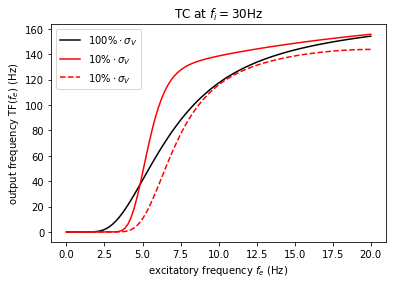

In [213]:
fe = np.linspace(0,20,100)
fi = 30
fout1 = TF2(PP,fe,fi,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-65e-3)
fout2 = TF2(PP,fe,fi,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-65e-3, noise=0.3)
PP2=PP.copy()
# PP2[2] = RE[2]
PP2[5]*=2
# PP2[8] = RE[8]
# PP2[9] = RE[9]
fout3 = TF2(PP2,fe,fi,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-65e-3, noise=0.3)
# fout1 = TF2(PP,fe,fi,0, Nexc=400,Ninh=150,Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3)
# fout2 = TF2(PP,fe,fi,0, Nexc=400,Ninh=150,Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3, noise=0.1)
plt.plot(fe,fout1,'black', label='$100\%\cdot\sigma_V$')
plt.plot(fe,fout2,'r', label='$10\%\cdot\sigma_V$')
plt.plot(fe,fout3,'--r', label='$10\%\cdot\sigma_V$')

plt.legend()
plt.xlabel("excitatory frequency $f_e$ (Hz)")
plt.ylabel("output frequency TF$(f_e)$ (Hz)")
plt.title("TC at $f_i=30$Hz");
# plt.savefig("NoiseTF_RE30Hz.png", dpi=250)

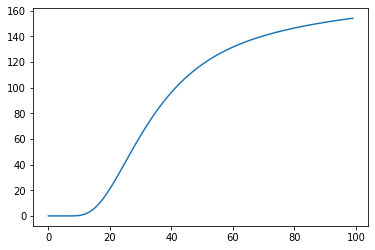

In [235]:
plt.plot(TF2(TC,fe,fi,0, Nexc=800,Ninh=25,Qe=1e-9,Qi=6e-9,Cm=160e-12,El=-65e-3))
# plt.plot(TF2(RE,fe,fi,0, Nexc=400,Ninh=150,Qe=4e-9,Qi=1e-9,Cm=200e-12,El=-75e-3))